# 01 - Uploading, Reading, & Preprocessing Image Data

### 1. Imports

In [485]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# os & image imports
import os
from PIL import Image

# tensorflow
import tensorflow as tf

# keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import Precision, Recall, SpecificityAtSensitivity, SensitivityAtSpecificity

# sklearn
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split # need this to split the train set into train/test for model training

To read the data in and also store the labels, I am going to make a dataframe by iterating through the contents of the `archive` folder under the `data` directory. Each images are further split into `Testing` and `Training` folders, each with separate directories for images corresponding to the type of tumor: Glioma, Meningioma, Pituitary, No Tumor.

In [11]:
# define paths to test & train directories
test_directory = './data/archive/Testing'
train_directory = './data/archive/Training'

---
### 2. Manual Preprocessing

In [167]:
def image_to_df(filepath):
    
    base = os.listdir(filepath)
    base.remove('.DS_Store') # removes this element from the list, remaining should be the actual folders
    
    X = []
    y = []
    img_path = []
    folder_path = []
    
    for folder_name in base:
        images = os.listdir(filepath + f'/{folder_name}')
        for i in images:
            if i.endswith(".jpg"):
                image = Image.open(f'{filepath}/{folder_name}/{i}') # open the image
                image = image.resize((256,256)) # resize to 256x256
                image = image.convert('L') # convert all to grayscale
                image = np.array(image) / 255. # turn image into an array of matrices & rescale!
                X.append(image)
                y.append(folder_name)
                img_path.append(f'{filepath}/{folder_name}/{i}')
                folder_path.append(f'{filepath}/{folder_name}')
            
    return pd.DataFrame(data={'folder_path': folder_path,'img_path': img_path, 'image_data': X, 'label': y})

In [168]:
# storing the output of the function for test data
test_df = image_to_df(test_directory)

In [413]:
# storing the output of the function for train data
train_df = image_to_df(train_directory)

In [170]:
test_df.head()

,folder_path,img_path,image_data,label
0,./data/archive/Testing/pituitary,./data/archive/Testing/pituitary/Te-pi_0233.jpg,"[[0.0, 0.0, 0.0, 0.00392156862745098, 0.0, 0.0...",pituitary
1,./data/archive/Testing/pituitary,./data/archive/Testing/pituitary/Te-pi_0227.jpg,"[[0.00392156862745098, 0.00392156862745098, 0....",pituitary
2,./data/archive/Testing/pituitary,./data/archive/Testing/pituitary/Te-pi_0019.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",pituitary
3,./data/archive/Testing/pituitary,./data/archive/Testing/pituitary/Te-pi_0031.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",pituitary
4,./data/archive/Testing/pituitary,./data/archive/Testing/pituitary/Te-pi_0025.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",pituitary


In [414]:
train_df.head()

,folder_path,img_path,image_data,label
0,./data/archive/Training/pituitary,./data/archive/Training/pituitary/Tr-pi_0505.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",pituitary
1,./data/archive/Training/pituitary,./data/archive/Training/pituitary/Tr-pi_0263.jpg,"[[0.00392156862745098, 0.00392156862745098, 0....",pituitary
2,./data/archive/Training/pituitary,./data/archive/Training/pituitary/Tr-pi_0277.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",pituitary
3,./data/archive/Training/pituitary,./data/archive/Training/pituitary/Tr-pi_1169.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",pituitary
4,./data/archive/Training/pituitary,./data/archive/Training/pituitary/Tr-pi_0511.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00...",pituitary


**NOTE:** I went back after the fact to add this. I did not have a separate validation dataset before. I will use train/test/split from sklearn to split my `train_df` further into train/validation set, so that when I train my CNN model, it will not see the testing data. <br>

I will have 30% of the train data for validation purposes, and the remaining for training the CNN. There are 5712 images total in the train set, so this should be enough for the model to learn.

In [415]:
train_df, val_df = train_test_split(train_df, test_size = 0.30, train_size = 0.70, stratify = train_df['label'])

Let's quickly look to see class proportions in the dataset.

In [420]:
round(train_df['label'].value_counts(normalize = True), 2)

label
notumor       0.28
pituitary     0.26
meningioma    0.23
glioma        0.23
Name: proportion, dtype: float64

In [423]:
print('This should be very roughly the same as the train_df')
round(val_df['label'].value_counts(normalize = True), 2)

This should be very roughly the same as the train_df


label
notumor       0.28
pituitary     0.25
meningioma    0.23
glioma        0.23
Name: proportion, dtype: float64

In [424]:
round(test_df['label'].value_counts(normalize = True), 2)

label
notumor       0.31
meningioma    0.23
pituitary     0.23
glioma        0.23
Name: proportion, dtype: float64

In [425]:
print(f'Images in Training across all 4 classes: {len(train_df)}')
print("===============================================")
print(f'Images in Validation across all 4 classes: {len(val_df)}')
print("===============================================")
print(f'Images in Testing across all 4 classes: {len(test_df)}')

Images in Training across all 4 classes: 3998
Images in Validation across all 4 classes: 1714
Images in Testing across all 4 classes: 1311


In [427]:
print(f'Testing image array: {test_df.iloc[0,2].shape}')
print(f'Validation image array: {test_df.iloc[0,2].shape}')
print(f'Training image array: {train_df.iloc[0,2].shape}')
print("===============================================")
print('256 x 256 is expected since I resized the images in my above function.')

Testing image array: (256, 256)
Validation image array: (256, 256)
Training image array: (256, 256)
256 x 256 is expected since I resized the images in my above function.


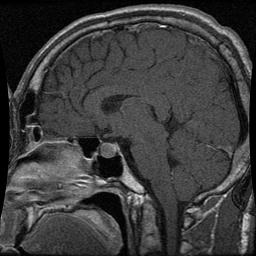

In [428]:
# let's take a look at some image samples
Image.open(train_df.iloc[0,1])

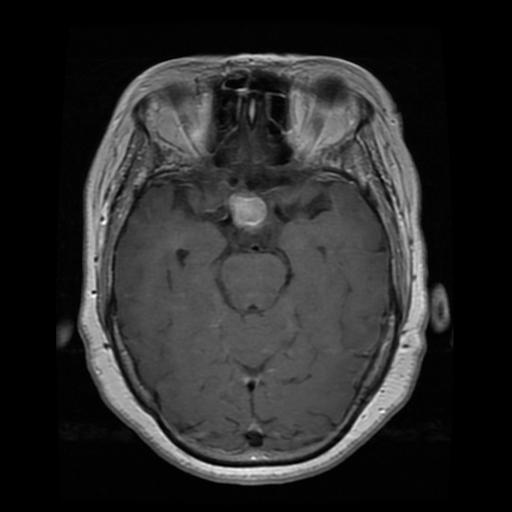

In [429]:
Image.open(train_df.iloc[45,1])

In [176]:
#### EDA CAN BE PERFORMED HERE ON THE CLASS LABELS AND PORTION OF EACH CLASS (or in a separate jpynb)

---
### 3. Preprocessing with `ImageDataGenerator()`

In [567]:
# instantiate ImageDataGenerator Class (called 'idg') for train and val
idg_train = ImageDataGenerator(rescale = 1./255,
                              brightness_range=(0.8, 1.2))

idg_val = ImageDataGenerator(rescale = 1./255,
                            brightness_range=(0.8, 1.2))


# keep testing separate
idg_test = ImageDataGenerator(rescale = 1./255,) 

#### **1. Training Data Generator**

In [568]:
train_data_gen = idg_train.flow_from_dataframe(train_df, 
                             x_col = 'img_path', 
                             y_col = 'label',
                             class_mode = 'categorical',
                             target_size = (256,256),
                             batch_size = 32,
                             color_mode = 'rgb',
                             classes = {'notumor': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}) # setting the default class indices

Found 3998 validated image filenames belonging to 4 classes.


In [569]:
# dictionary - numerical representations for each categorical var
train_data_gen.class_indices

{'notumor': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}

#### **2. Validation Data Generator**

In [570]:
# the set up here should be the same as 'train_data_gen'
val_data_gen = idg_val.flow_from_dataframe(val_df, 
                             x_col = 'img_path', 
                             y_col = 'label',
                             class_mode = 'categorical',
                             target_size = (256,256),
                             batch_size = 32,
                             color_mode = 'rgb',
                             classes = {'notumor': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}) # setting the default class indices

Found 1714 validated image filenames belonging to 4 classes.


In [571]:
# dictionary - numerical representations for each categorical var
val_data_gen.class_indices

{'notumor': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}

#### **3. Testing Data Generator**

In [572]:
test_data_gen = idg_test.flow_from_dataframe(test_df, 
                             x_col = 'img_path', 
                             y_col = 'label',
                             class_mode = 'categorical',
                             target_size = (256,256),
                             batch_size = 32,
                             color_mode = 'rgb',
                             shuffle = False,
                             classes = {'notumor': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}) # setting the default class indices

Found 1311 validated image filenames belonging to 4 classes.


In [573]:
# ensure labels are presented the same as train
test_data_gen.class_indices

{'notumor': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}

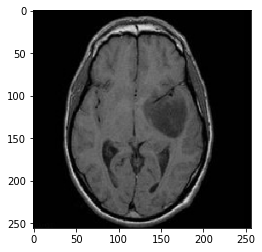

In [592]:
# sample resized image from the testing set
augmented_image = test_data_gen.next()[0][31]
plt.imshow(augmented_image)

In [ ]:
augmented_image = train_data_gen.next()[33][0]
plt.imshow(augmented_image)

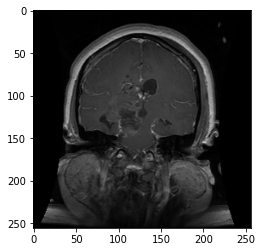

In [576]:
augmented_image = val_data_gen.next()[0][0]
plt.imshow(augmented_image)

In [577]:
print(train_data_gen.image_shape)
print(val_data_gen.image_shape)
print(test_data_gen.image_shape)

# this is accurate (256x256 size) and 3 for the channel ('RGB')

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


---
### 4. Building the First Model

In [469]:
# instantiating Sequential model, 'model_1'
model_1 = Sequential()

# layer 1
model_1.add(Conv2D(32, 3, activation = "relu", input_shape = (256, 256, 3))) # input shape is 256 x 256, 3 channels
model_1.add(MaxPooling2D(pool_size = 2))

# layer 2
model_1.add(Conv2D(64, 3, activation = "relu",)) # NOTE: no need for an additional input shape here, only needed for the first blocj
model_1.add(MaxPooling2D(pool_size = 2))

# # layer 3
# model_1.add(Conv2D(128, 3, activation = "relu", input_shape = (256, 256, 3)))
# model_1.add(MaxPooling2D(pool_size = 2))

# # layer 4
# model_1.add(Conv2D(256, 3, activation = "relu", input_shape = (256, 256, 3)))
# model_1.add(MaxPooling2D(pool_size = 2))

# flatten
model_1.add(Flatten()) 

# output layer
model_1.add(Dense(4, activation = 'softmax')) # we want 4 outputs (4 classes) and 'softmax' activation to give us the probability

# let's view a summary of model_1
print(f"Model Summary:")
print("="*20)
print(model_1.summary())

# compiling the model
model_1.compile(optimizer = 'rmsprop',
               loss = 'categorical_crossentropy', # need categorical_crossentropy since multiclass classification
               metrics = ['accuracy', Precision(), Recall()])

Model Summary:
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_11 (Flatten)        (None, 246016)            0         
                                                                 
 dense_11 (Dense)            (None, 4)

In [470]:
# fitting the model to training data
history_1 = model_1.fit(train_data_gen, epochs = 10, validation_data = val_data_gen)

Epoch 1/10
125/125 [==============================] - 165s 1s/step - loss: 0.8376 - accuracy: 0.6976 - precision_9: 0.7753 - recall_9: 0.5988 - val_loss: 0.5236 - val_accuracy: 0.8011 - val_precision_9: 0.8265 - val_recall_9: 0.7754
Epoch 2/10
125/125 [==============================] - 155s 1s/step - loss: 0.3822 - accuracy: 0.8644 - precision_9: 0.8786 - recall_9: 0.8439 - val_loss: 0.3521 - val_accuracy: 0.8734 - val_precision_9: 0.8844 - val_recall_9: 0.8571
Epoch 3/10
125/125 [==============================] - 168s 1s/step - loss: 0.2133 - accuracy: 0.9260 - precision_9: 0.9325 - recall_9: 0.9185 - val_loss: 0.2945 - val_accuracy: 0.9125 - val_precision_9: 0.9186 - val_recall_9: 0.9084
Epoch 4/10
125/125 [==============================] - 164s 1s/step - loss: 0.1182 - accuracy: 0.9632 - precision_9: 0.9646 - recall_9: 0.9600 - val_loss: 0.2580 - val_accuracy: 0.9247 - val_precision_9: 0.9254 - val_recall_9: 0.9195
Epoch 5/10
125/125 [==============================] - 162s 1s/step -

---

### 5. Evaluating the Model

In [471]:
# the .history attribute outputs a dictionary of the metrics over each epoch the model ran for both training and validation sets
history_1.history

{'loss': [0.8375788331031799,
  0.3821586072444916,
  0.21325719356536865,
  0.11822956055402756,
  0.06619170308113098,
  0.037692856043577194,
  0.02181168459355831,
  0.015185197815299034,
  0.005652079824358225,
  0.009881850332021713],
 'accuracy': [0.6975988149642944,
  0.8644322156906128,
  0.9259629845619202,
  0.96323162317276,
  0.9769884943962097,
  0.9879940152168274,
  0.9924962520599365,
  0.9954977631568909,
  0.9987493753433228,
  0.9967483878135681],
 'precision_9': [0.7752590775489807,
  0.8786458373069763,
  0.9324530363082886,
  0.9645639657974243,
  0.977711021900177,
  0.9887331128120422,
  0.9924962520599365,
  0.9954977631568909,
  0.9987493753433228,
  0.9967483878135681],
 'recall_9': [0.5987994074821472,
  0.843921959400177,
  0.9184592366218567,
  0.9599800109863281,
  0.9764882326126099,
  0.9877438545227051,
  0.9924962520599365,
  0.9954977631568909,
  0.9987493753433228,
  0.9967483878135681],
 'val_loss': [0.5236127376556396,
  0.35208940505981445,
  0.

#### 1. **Graphing Training vs. Validation Loss, Accuracy, Precision, & Recall**

In [472]:
history_1.history.keys()

dict_keys(['loss', 'accuracy', 'precision_9', 'recall_9', 'val_loss', 'val_accuracy', 'val_precision_9', 'val_recall_9'])

In [473]:
# let's save the history output in separate lists
train_loss = history_1.history['loss']
train_acc = history_1.history['accuracy']
train_precision = history_1.history['precision_9']
train_recall = history_1.history['recall_9']

val_loss = history_1.history['val_loss']
val_acc = history_1.history['val_accuracy']
val_precision = history_1.history['val_precision_9']
val_recall = history_1.history['val_recall_9']

epochs = [i+1 for i in history_1.epoch] # quick list comprehension since the original epochs list is from 0 - 9

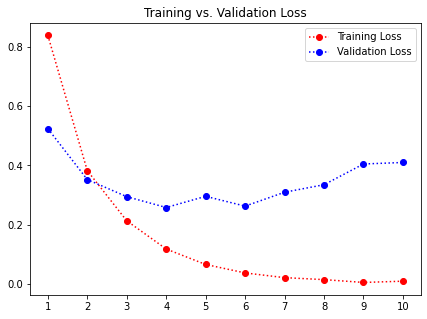

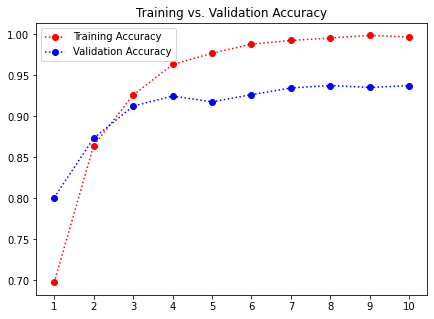

In [474]:
# plotting
plt.figure(figsize = (7,5))
plt.plot(epochs, train_loss, 'o:r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'o:b', label = 'Validation Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.xticks(epochs)
plt.savefig('./graphs/train_val_loss.jpeg', dpi = 1080);

# some overfitting, but not extremely overfit
# validation loss ceases to improve after 7th epoch

plt.figure(figsize = (7,5))
plt.plot(epochs, train_acc, 'o:r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'o:b', label = 'Validation Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')
plt.xticks(epochs)
plt.savefig('./graphs/train_val_accuracy.jpeg', dpi = 1080);

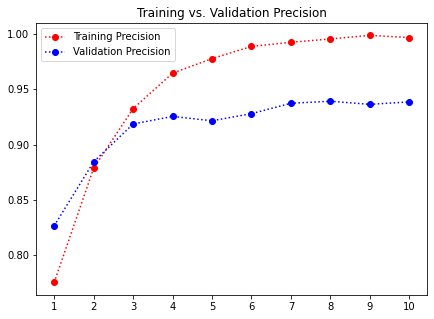

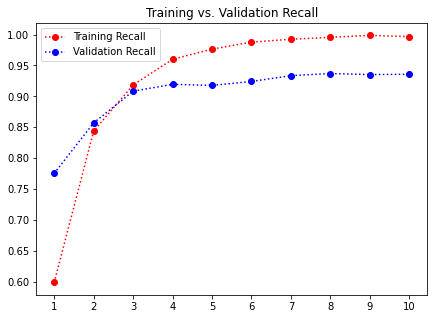

In [475]:
# plotting
plt.figure(figsize = (7,5))
plt.plot(epochs, train_precision, 'o:r', label = 'Training Precision')
plt.plot(epochs, val_precision, 'o:b', label = 'Validation Precision')
plt.legend()
plt.title('Training vs. Validation Precision')
plt.xticks(epochs)
plt.savefig('./graphs/train_val_precision.jpeg', dpi = 1080);

# some overfitting, but not extremely overfit
# validation loss ceases to improve after 7th epoch

plt.figure(figsize = (7,5))
plt.plot(epochs, train_recall, 'o:r', label = 'Training Recall')
plt.plot(epochs, val_recall, 'o:b', label = 'Validation Recall')
plt.legend()
plt.title('Training vs. Validation Recall')
plt.xticks(epochs)
plt.savefig('./graphs/train_val_recall.jpeg', dpi = 1080);

Across all metrics, after about the 7th epoch, the validation scores seemed to plateu. There is little bit of overfitting with the difference between the training and vaidation scores hovering between 2-3%. <br> 

To make the model stronger and reduce overfitting, I can add a Dropout layer. The previous model already included augmenting the training images, but adding a Dropout layer may mitigate some of the overfitting a little more. To make the model even stronger, I can also include a pre-trained base model and append my own additional layers to initiate transfer learning.

In [476]:
# let's evaluate the model on the testing dataset now
model_1.evaluate(test_data_gen)

41/41 [==============================] - 12s 283ms/step - loss: 0.4420 - accuracy: 0.9336 - precision_9: 0.9336 - recall_9: 0.9336


[0.44195854663848877,
 0.9336384534835815,
 0.9336384534835815,
 0.9336384534835815]

#### 2. Generating Predictions & Confusion Matrix

In [480]:
preds_1 = model_1.predict(test_data_gen)

41/41 [==============================] - 13s 314ms/step


In [481]:
preds_1

array([[9.9999994e-01, 5.1237369e-12, 1.8709413e-08, 4.4956400e-13],
       [3.4531510e-08, 9.9977779e-01, 2.2225524e-04, 1.4003385e-09],
       [9.9997264e-01, 1.1233301e-16, 7.4158119e-10, 2.7348211e-05],
       ...,
       [2.5856300e-06, 3.7229122e-12, 5.9765056e-02, 9.4023234e-01],
       [1.6164671e-09, 2.9308469e-21, 8.5997122e-13, 1.0000000e+00],
       [1.9864072e-05, 9.9368978e-01, 6.2894793e-03, 8.5268863e-07]],
      dtype=float32)

In [479]:
preds_1 = np.argmax(preds_1, axis = 1)
preds_1

array([2, 0, 2, ..., 2, 1, 0])

In [454]:
# creating a confusion matrix
conf_matrix = confusion_matrix(test_data_gen.classes, preds_1)

conf_matrix = ConfusionMatrixDisplay(conf_matrix, display_labels = test_data_gen.class_indices)

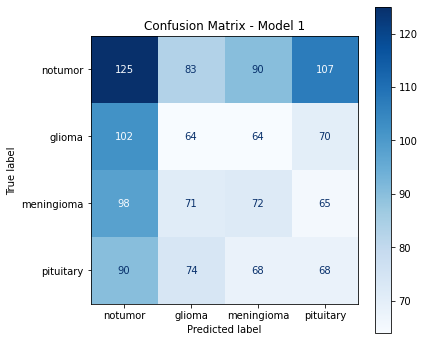

In [482]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
conf_matrix.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Confusion Matrix - Model 1')
plt.savefig('./graphs/cm_model1.jpeg', dpi = 1080)
plt.show()

In [594]:
(preds_1 == test_data_gen.classes).mean()

<ipython-input-594-067a2e1c3384>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  (preds_1 == test_data_gen.classes).mean()


AttributeError: 'bool' object has no attribute 'mean'

This model 1 is performing very poorly on the testing dataset. The validation metrics for loss, accuracy, precision, and recall were very promising. However, it seems that the CNN is extremely overfit, since the model is predicting roughly at or ***below*** the baseline for every single class.

### 6. Building a Better Model via Transfer Learning - {name of pretrained model here}

In [593]:
# instantiate Xception class
pretrained_base = tf.keras.applications.Xception(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3), pooling = 'max')


# instantiating Sequential model, 'model_1'
model_2 = Sequential(pretrained_base)

# # block 1
# model_2.add(Conv2D(32, 3, activation = "relu", input_shape = (256, 256, 3)))
# model_2.add(MaxPooling2D(pool_size = 2))
# model_2.add(Dropout(0.20))

# # block 2
# model_2.add(Conv2D(64, 3, activation = "relu",)) # NOTE: no need for an additional input shape here, only needed for the first blocj
# model_2.add(MaxPooling2D(pool_size = 2))
# model_2.add(Dropout(0.20)) 

# flatten
model_2.add(Flatten()) 
model_2.add(Dropout(0.20)) 
            
# adding dense layers
model_2.add(Dense(64, activation = "relu"))
model_2.add(Dropout(0.20))

# output layer
model_2.add(Dense(4, activation = 'softmax')) # we want 4 outputs (4 classes) and 'softmax' activation to give us the probability

            
# let's view a summary of model_1
print(f"Model Summary:")
print("="*20)
print(model_2.summary())

# compiling the model
model_2.compile(optimizer = 'rmsprop',
               loss = 'categorical_crossentropy', # need categorical_crossentropy since multiclass classification
               metrics = ['accuracy', Precision(), Recall()])

Model Summary:
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_16 (Flatten)        (None, 2048)              0         
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0         
                                                                 
 dense_20 (Dense)            (None, 64)                131136    
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 4)                 260       
                                                                 
Total params: 20992876 (80.08 MB)
Trai

In [ ]:
history_2 = model_2.fit(train_data_gen, epochs = 10, validation_data = val_data_gen, shuffle = False)

Epoch 1/10
 38/125 [========>.....................] - ETA: 19:31 - loss: 1.3131 - accuracy: 0.4202 - precision_13: 0.7570 - recall_13: 0.1332

In [507]:
history_2.history

{'loss': [0.5802164673805237,
  0.20921680331230164,
  0.11997120082378387,
  0.07630973309278488,
  0.07288620620965958,
  0.05258437246084213,
  0.06349416077136993,
  0.05772249773144722,
  0.03465373069047928,
  0.02174035832285881],
 'accuracy': [0.7963982224464417,
  0.9379689693450928,
  0.9654827117919922,
  0.9779890179634094,
  0.9837418794631958,
  0.9839919805526733,
  0.9867433905601501,
  0.9857428669929504,
  0.9897449016571045,
  0.9939969778060913],
 'precision_11': [0.8810110688209534,
  0.9495389461517334,
  0.9684502482414246,
  0.979899525642395,
  0.9846925735473633,
  0.9856891632080078,
  0.987201988697052,
  0.9867101311683655,
  0.9912302494049072,
  0.9944931268692017],
 'recall_11': [0.7148573994636536,
  0.9272136092185974,
  0.9597298502922058,
  0.9754877686500549,
  0.9814907312393188,
  0.9819909930229187,
  0.9839919805526733,
  0.9842421412467957,
  0.9894947409629822,
  0.9937468767166138],
 'val_loss': [2.4790725708007812,
  0.6875976920127869,
  0.

In [508]:
preds_2 = model_2.predict(test_data_gen)

41/41 [==============================] - 132s 3s/step


In [514]:
preds_2

array([[3.2972613e-30, 8.0686708e-32, 9.9999994e-01, 3.7938963e-29],
       [1.6023374e-20, 9.9999994e-01, 1.2423759e-15, 1.0272098e-18],
       [3.4710667e-13, 4.6686255e-19, 9.9999994e-01, 7.6537061e-16],
       ...,
       [1.0000000e+00, 5.0109914e-14, 1.4220270e-11, 7.5717243e-13],
       [4.7190496e-33, 3.4415228e-34, 6.0237517e-25, 1.0000000e+00],
       [3.5879893e-22, 1.2302225e-23, 1.0000000e+00, 1.0333591e-21]],
      dtype=float32)

In [517]:
preds_2 = np.argmax(preds_2, axis = 1)

In [518]:
# creating a confusion matrix
conf_matrix_2 = confusion_matrix(test_data_gen.classes, preds_2)

conf_matrix_2 = ConfusionMatrixDisplay(conf_matrix_2, display_labels = test_data_gen.class_indices)

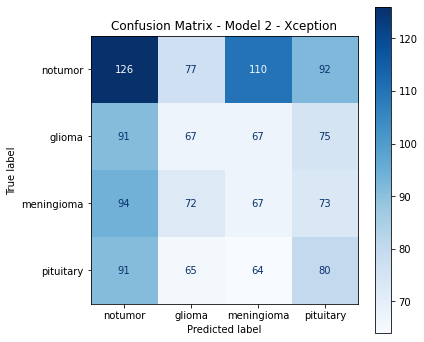

In [519]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
conf_matrix_2.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Confusion Matrix - Model 2 - Xception')
plt.savefig('./graphs/cm_model2.jpeg', dpi = 1080)
plt.show()

In [525]:
(preds_2 == test_data_gen.classes).mean()
# it's just guessing at random lol

0.2593440122044241